**Travelling Salesman Problem**

Problem Statement - Given a list of cities and the distances between each pair of cities, what is the shortest possible route that visits each city and returns to the origin city?

There are two important rules

1.   Each city needs to be visited exactly one time
2.   We must return to the starting city, so our total distance needs to be calculated accordingly



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Genetic algorithm for Travelling Salesman Problem**

The GA will be done based on the following steps

1.   Create the population
2.   Determine fitness
3.   Select the mating pool
4.   Breed
5.   Mutate
6.   Repeat


**TSA mapped as GA problem**

1.   **Gene** - a city represented by x,y coordinates.
2.   **Individual** -  a single route satisfying the tsa conditions.
3.   **Population** - a group of individuals.
4.   **Parents** - two routes that are combined to create a new route.
5.   **Mating Pool** - a collection of parents used to create the next population.
6.   **Fitness** - a function that tells us how good each route is. (how short the distance is).
7.   **Mutation** - a way to introduce varioation in the population (randomly swapping 2 cities in route in this case).
8.   **Elitism** -  a way to carry the best individuals into the next generation.

In [2]:
# Gene - A city is a class with x,y coordinates.
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance

    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"

In [3]:
#Example City
import random
c = City(x = int(random.random() * 100), y = int(random.random() * 100))
c.__repr__()

'(34,6)'

In [4]:
# Calculating Fitness - Here we use distance as the fitness function, we will treat fitness as inverse
# of the route distance so that we can maximize the function to get
# shortest distance.

class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness = 0.0

    def routeDistance(self):
        if self.distance ==0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance

    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness

In [5]:
#Individual - Creating a single route based on the cities randomly
import random

def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    return route

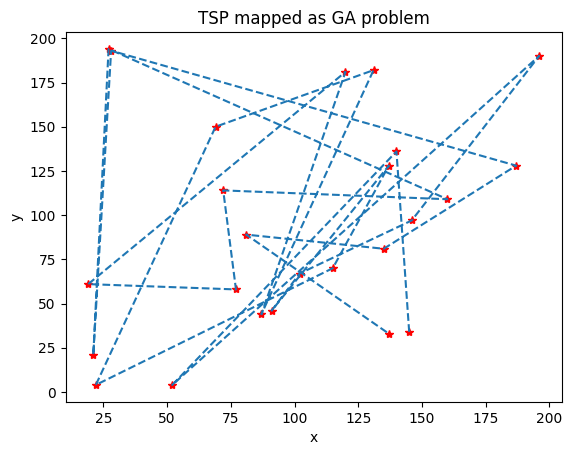

In [6]:
#Example route
cityList = []

for i in range(0,25):
    cityList.append(City(x=int(random.random() * 200), y=int(random.random() * 200)))

route = createRoute(cityList)

x = [city.x for city in cityList]
y = [city.y for city in cityList]

route_point_x = [route[i].x for i in range(len(route))]
route_point_y = [route[i].y for i in range(len(route))]

plt.plot(x,y,'r*')
plt.plot(route_point_x,route_point_y,'--')
plt.title('TSP mapped as GA problem')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

print(route)

In [7]:
# Population (A group of individuals (routes)) - We now make our initial population.
# Randomly producing the routes that satisfy the TSP conditions.

def initialPopulation(popSize, cityList):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population

[(145,34), (140,136), (52,4), (196,190), (146,97), (102,67), (91,46), (137,128), (115,70), (22,4), (69,150), (131,182), (87,44), (120,181), (19,61), (77,58), (72,114), (160,109), (27,194), (21,21), (28,193), (187,128), (135,81), (81,89), (137,33)]


In [8]:
# Ranking fitness - We rank each individual of the population based on how
# short the distance is

import operator

def rankRoutes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

**Select the mating pool**

We will use fitness proportionate selection (roulette wheel selection) for this.

**Fitness proportionate selection** - The fitness of each individual relative to the population is used to assign a probability of selection. Think of this as the fitness-weighted probability of being selected.

**Elitism** - With elitism, the best performing individuals from the population will automatically carry over to the next generation, ensuring that the most successful individuals persist.

In [9]:
def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()

    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

In [10]:
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

**Breed**

We can create the next generation in the process called breeding (crossover). We
use special breeding function called ordered crossover for TSP.

**Ordered Crossover** -  In ordered crossover, we randomly select a subset of the first parent string and then fill the remainder of the route with the genes from the second parent in the order in which they appear, without duplicating any genes in the selected subset from the first parent.
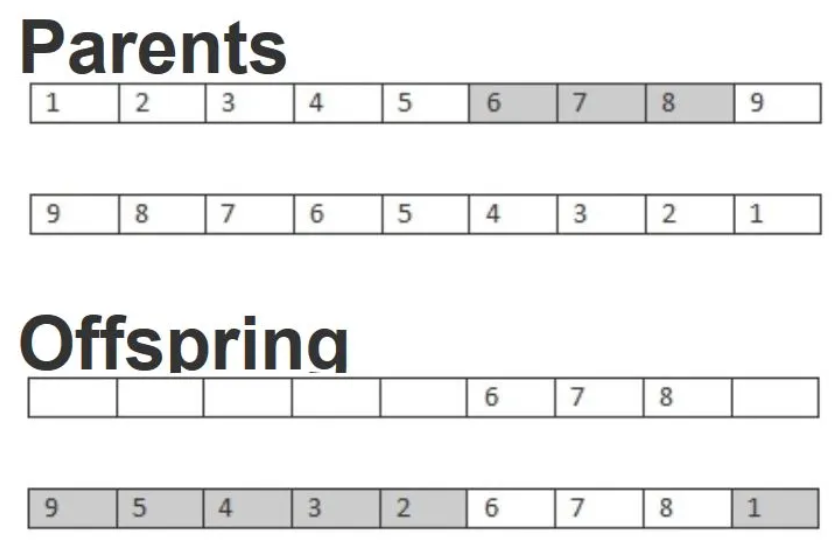


In [11]:
def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []

    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))

    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])

    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    return child

In [12]:
def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])

    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children

**Mutate**

It helps to avoid local convergence by introducint novel routes that will allow us to explore other parts of the solution space. For TSP we use swap mutation.

**Swap Mutation** - This means that, with specified low probability, two cities will swap places in our route.

In [13]:
def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))

            city1 = individual[swapped]
            city2 = individual[swapWith]

            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

In [14]:
def mutatePopulation(population, mutationRate):
    mutatedPop = []

    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

**Next Generation Computation**

In [15]:
# Now we compute the next generation using the previous functions

def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

**Evolving for generations**

In [16]:
def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1])) # Inverse to get the distane from fitness score

    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)

    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    return bestRoute

**Running the GA**

In [17]:
cityList = []

for i in range(0,25):
    cityList.append(City(x=int(random.random() * 200), y=int(random.random() * 200)))

In [18]:
def geneticAlgorithmPlot(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))
    progress = []
    progress.append(1 / rankRoutes(pop)[0][1])

    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(pop)[0][1])

    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.show()


    return bestRoute

Initial distance: 1991.7234253568447
Final distance: 908.5960752804648


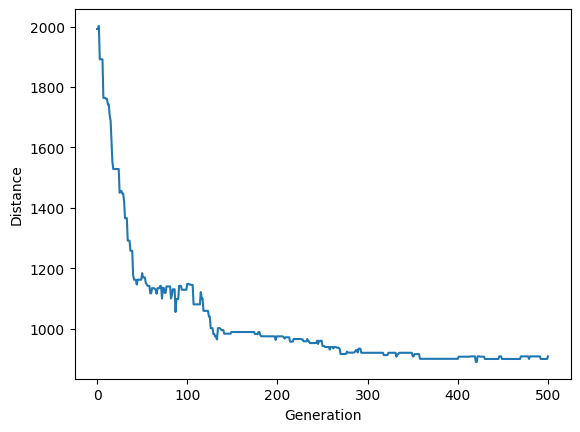

[(64,160), (60,92), (65,78), (72,76), (76,81), (95,98), (136,112), (174,132), (177,130), (159,64), (142,51), (172,24), (188,11), (87,10), (43,9), (27,90), (51,130), (46,148), (20,172), (1,183), (20,198), (40,197), (68,172), (108,190), (77,148)]


In [19]:
#geneticAlgorithm(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=500)
bestroute = geneticAlgorithmPlot(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=500)
print(bestroute)


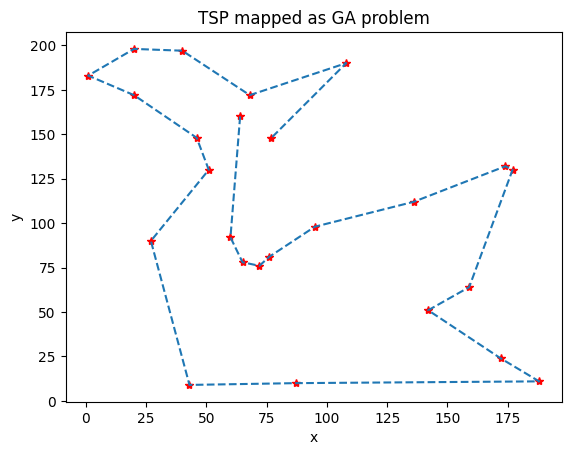

[(64,160), (60,92), (65,78), (72,76), (76,81), (95,98), (136,112), (174,132), (177,130), (159,64), (142,51), (172,24), (188,11), (87,10), (43,9), (27,90), (51,130), (46,148), (20,172), (1,183), (20,198), (40,197), (68,172), (108,190), (77,148)]


In [20]:
x = [city.x for city in cityList]
y = [city.y for city in cityList]

route_point_x = [bestroute[i].x for i in range(len(bestroute))]
route_point_y = [bestroute[i].y for i in range(len(bestroute))]

plt.plot(x,y,'r*')
plt.plot(route_point_x,route_point_y,'--')
plt.title('TSP mapped as GA problem')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

print(bestroute)

**2D Cellular Automata Simulation**

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import random

population_size = 100

In [22]:
N = 10
arr = np.random.choice([0, 1], size=(N,N))
print(arr)

[[0 1 1 0 0 1 1 0 0 0]
 [1 1 1 1 1 1 0 1 0 0]
 [0 0 1 0 1 0 0 1 0 0]
 [0 1 0 1 0 0 0 1 1 1]
 [1 1 1 0 1 0 1 0 0 0]
 [1 0 1 1 1 0 0 1 0 1]
 [0 0 1 0 0 1 0 0 0 1]
 [0 1 1 1 1 1 1 0 1 1]
 [1 1 0 1 1 0 0 1 0 1]
 [0 1 0 1 0 0 0 0 0 0]]


**Applying Rule 1 for Moore neighborhood**

The Moore neighborhood consists of a central cell (the one which is to be updated) and its eight geographical neighbors, north, west, south, east, north-east, north-west, south-west, and south-east, that is a total of nine cells. Each central cell can be alive (st = 1) or dead (st = 0). If permutations and combinations are used to describe neighbors’ states, many unnecessary duplicate data will be generated. Therefore, there is no need to enumerate the states and positions of specific neighbors; just calculate the total number of cellular states in neighbors. The sum of neighbors’ states is K; so, K can be any value between 0 and 8.

**Rule 1**

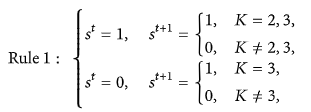

In [23]:
# NULL boundary conditions

arr_null_padded =  np.pad(arr, [(1, 1), (1, 1)], mode='constant', constant_values=0)
print(arr_null_padded)


[[0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 0 0 1 1 0 0 0 0]
 [0 1 1 1 1 1 1 0 1 0 0 0]
 [0 0 0 1 0 1 0 0 1 0 0 0]
 [0 0 1 0 1 0 0 0 1 1 1 0]
 [0 1 1 1 0 1 0 1 0 0 0 0]
 [0 1 0 1 1 1 0 0 1 0 1 0]
 [0 0 0 1 0 0 1 0 0 0 1 0]
 [0 0 1 1 1 1 1 1 0 1 1 0]
 [0 1 1 0 1 1 0 0 1 0 1 0]
 [0 0 1 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]]


In [24]:
out_arr = np.zeros((N+2,N+2))
for i in range(1,N+1):
  for j in range(1,N+1):
    sum = arr_null_padded[i,j-1] + arr_null_padded[i,j+1] + arr_null_padded[i-1,j-1] + arr_null_padded[i-1,j] + arr_null_padded[i-1,j+1] + arr_null_padded[i+1,j-1] + arr_null_padded[i+1,j] + arr_null_padded[i+1,j+1]
    if(arr_null_padded[i][j] == 1):
      if(sum == 2 or sum == 3):
        out_arr[i,j] = 1
      else:
        out_arr[i,j] = 0
    else:
      if(sum == 3):
        out_arr[i,j] = 1
      else:
        out_arr[i,j] = 0

print(out_arr)
print('Number of living cells: ' + str(np.sum(out_arr)))

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0.]
 [0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0.]
 [0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Number of living cells: 37.0


Evolving the Rule 1 with NULL bounary conditions for 100 iterations

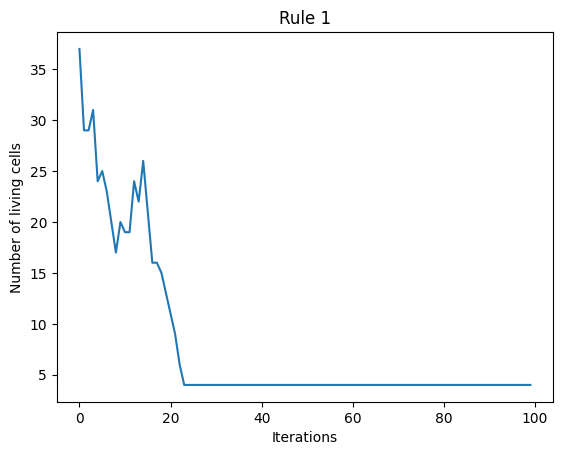

In [25]:
iterations = 100
temp_arr = arr_null_padded
out_arr = np.zeros((N+2,N+2))
living_cells = []
for itr in range(iterations):
  for i in range(1,N+1):
    for j in range(1,N+1):
      sum = temp_arr[i,j-1] + temp_arr[i,j+1] + temp_arr[i-1,j-1] + temp_arr[i-1,j] + temp_arr[i-1,j+1] + temp_arr[i+1,j-1] + temp_arr[i+1,j] + temp_arr[i+1,j+1]
      if(temp_arr[i][j] == 1):
        if(sum == 2 or sum == 3):
          out_arr[i,j] = 1
        else:
          out_arr[i,j] = 0
      else:
        if(sum == 3):
          out_arr[i,j] = 1
        else:
          out_arr[i,j] = 0

  temp_arr = out_arr
  living_cells.append(np.sum(out_arr))
  out_arr = np.zeros((N+2,N+2))

plt.plot(living_cells)
plt.xlabel('Iterations')
plt.ylabel('Number of living cells')
plt.title('Rule 1')
plt.show()

Evolving Rule 1 with periodic boundary conditions for 100 iterations

In [26]:
arr_periodic_padded =  np.pad(arr, [(1, 1), (1, 1)], mode='wrap')
print(arr_periodic_padded)

[[0 0 1 0 1 0 0 0 0 0 0 0]
 [0 0 1 1 0 0 1 1 0 0 0 0]
 [0 1 1 1 1 1 1 0 1 0 0 1]
 [0 0 0 1 0 1 0 0 1 0 0 0]
 [1 0 1 0 1 0 0 0 1 1 1 0]
 [0 1 1 1 0 1 0 1 0 0 0 1]
 [1 1 0 1 1 1 0 0 1 0 1 1]
 [1 0 0 1 0 0 1 0 0 0 1 0]
 [1 0 1 1 1 1 1 1 0 1 1 0]
 [1 1 1 0 1 1 0 0 1 0 1 1]
 [0 0 1 0 1 0 0 0 0 0 0 0]
 [0 0 1 1 0 0 1 1 0 0 0 0]]


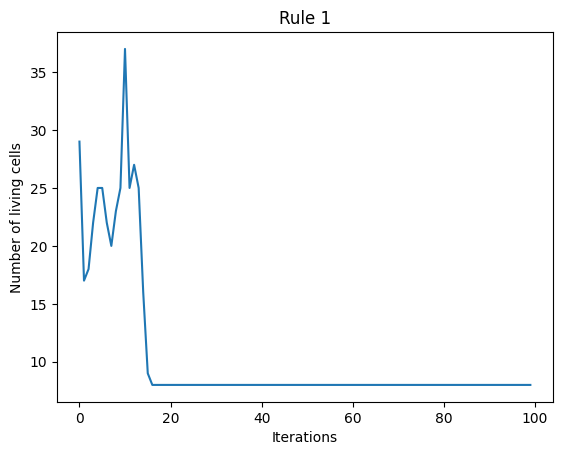

In [27]:
iterations = 100
temp_arr = arr_periodic_padded
out_arr = np.zeros((N+2,N+2))
living_cells = []
for itr in range(iterations):
  for i in range(1,N+1):
    for j in range(1,N+1):
      sum = temp_arr[i,j-1] + temp_arr[i,j+1] + temp_arr[i-1,j-1] + temp_arr[i-1,j] + temp_arr[i-1,j+1] + temp_arr[i+1,j-1] + temp_arr[i+1,j] + temp_arr[i+1,j+1]
      if(temp_arr[i][j] == 1):
        if(sum == 2 or sum == 3):
          out_arr[i,j] = 1
        else:
          out_arr[i,j] = 0
      else:
        if(sum == 3):
          out_arr[i,j] = 1
        else:
          out_arr[i,j] = 0

  temp_arr = out_arr
  living_cells.append(np.sum(out_arr))
  out_arr = np.zeros((N+2,N+2))

plt.plot(living_cells)
plt.xlabel('Iterations')
plt.ylabel('Number of living cells')
plt.title('Rule 1')
plt.show()

**Evolving Rule 1,2 3 with NULL boundary conditions for 100 iterations**

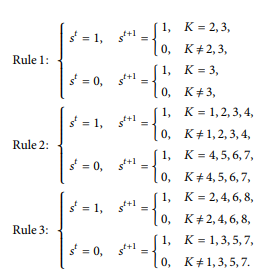

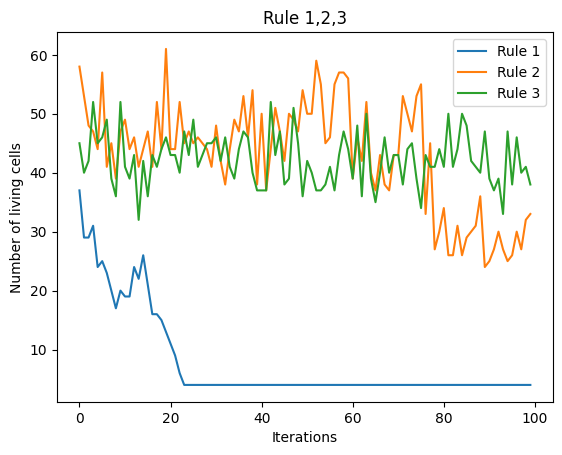

In [28]:
iterations = 100

#Rule 1
temp_arr = arr_null_padded
out_arr = np.zeros((N+2,N+2))
living_cells_rule1 = []
for itr in range(iterations):
  for i in range(1,N+1):
    for j in range(1,N+1):
      sum = temp_arr[i,j-1] + temp_arr[i,j+1] + temp_arr[i-1,j-1] + temp_arr[i-1,j] + temp_arr[i-1,j+1] + temp_arr[i+1,j-1] + temp_arr[i+1,j] + temp_arr[i+1,j+1]
      if(temp_arr[i][j] == 1):
        if(sum == 2 or sum == 3):
          out_arr[i,j] = 1
        else:
          out_arr[i,j] = 0
      else:
        if(sum == 3):
          out_arr[i,j] = 1
        else:
          out_arr[i,j] = 0

  temp_arr = out_arr
  living_cells_rule1.append(np.sum(out_arr))
  out_arr = np.zeros((N+2,N+2))

# Rule 2
temp_arr = arr_null_padded
out_arr = np.zeros((N+2,N+2))
living_cells_rule2 = []
for itr in range(iterations):
  for i in range(1,N+1):
    for j in range(1,N+1):
      sum = temp_arr[i,j-1] + temp_arr[i,j+1] + temp_arr[i-1,j-1] + temp_arr[i-1,j] + temp_arr[i-1,j+1] + temp_arr[i+1,j-1] + temp_arr[i+1,j] + temp_arr[i+1,j+1]
      if(temp_arr[i][j] == 1):
        if(sum == 1 or sum == 2 or sum == 3 or sum == 4):
          out_arr[i,j] = 1
        else:
          out_arr[i,j] = 0
      else:
        if(sum == 4 or sum == 5 or sum == 6 or sum == 7):
          out_arr[i,j] = 1
        else:
          out_arr[i,j] = 0

  temp_arr = out_arr
  living_cells_rule2.append(np.sum(out_arr))
  out_arr = np.zeros((N+2,N+2))


# Rule 3
temp_arr = arr_null_padded
out_arr = np.zeros((N+2,N+2))
living_cells_rule3 = []
for itr in range(iterations):
  for i in range(1,N+1):
    for j in range(1,N+1):
      sum = temp_arr[i,j-1] + temp_arr[i,j+1] + temp_arr[i-1,j-1] + temp_arr[i-1,j] + temp_arr[i-1,j+1] + temp_arr[i+1,j-1] + temp_arr[i+1,j] + temp_arr[i+1,j+1]
      if(temp_arr[i][j] == 1):
        if(sum == 2 or sum == 4 or sum == 6 or sum == 8):
          out_arr[i,j] = 1
        else:
          out_arr[i,j] = 0
      else:
        if(sum == 1 or sum == 3 or sum == 7 or sum == 7):
          out_arr[i,j] = 1
        else:
          out_arr[i,j] = 0

  temp_arr = out_arr
  living_cells_rule3.append(np.sum(out_arr))
  out_arr = np.zeros((N+2,N+2))

plt.plot(living_cells_rule1,label="Rule 1")
plt.plot(living_cells_rule2,label="Rule 2")
plt.plot(living_cells_rule3,label="Rule 3")
plt.legend(loc="upper right")
plt.xlabel('Iterations')
plt.ylabel('Number of living cells')
plt.title('Rule 1,2,3')
plt.show()

**Evolving Rule 1,2 3 with Periodic boundary conditions for 100 iterations**

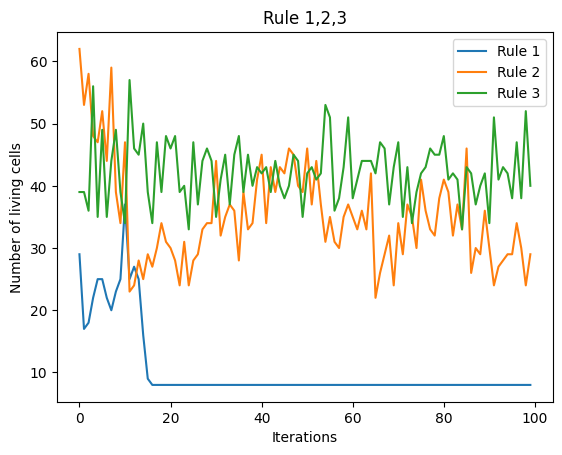

In [29]:
iterations = 100

#Rule 1
temp_arr = arr_periodic_padded
out_arr = np.zeros((N+2,N+2))
living_cells_rule1 = []
for itr in range(iterations):
  for i in range(1,N+1):
    for j in range(1,N+1):
      sum = temp_arr[i,j-1] + temp_arr[i,j+1] + temp_arr[i-1,j-1] + temp_arr[i-1,j] + temp_arr[i-1,j+1] + temp_arr[i+1,j-1] + temp_arr[i+1,j] + temp_arr[i+1,j+1]
      if(temp_arr[i][j] == 1):
        if(sum == 2 or sum == 3):
          out_arr[i,j] = 1
        else:
          out_arr[i,j] = 0
      else:
        if(sum == 3):
          out_arr[i,j] = 1
        else:
          out_arr[i,j] = 0

  temp_arr = out_arr
  living_cells_rule1.append(np.sum(out_arr))
  out_arr = np.zeros((N+2,N+2))

# Rule 2
temp_arr = arr_periodic_padded
out_arr = np.zeros((N+2,N+2))
living_cells_rule2 = []
for itr in range(iterations):
  for i in range(1,N+1):
    for j in range(1,N+1):
      sum = temp_arr[i,j-1] + temp_arr[i,j+1] + temp_arr[i-1,j-1] + temp_arr[i-1,j] + temp_arr[i-1,j+1] + temp_arr[i+1,j-1] + temp_arr[i+1,j] + temp_arr[i+1,j+1]
      if(temp_arr[i][j] == 1):
        if(sum == 1 or sum == 2 or sum == 3 or sum == 4):
          out_arr[i,j] = 1
        else:
          out_arr[i,j] = 0
      else:
        if(sum == 4 or sum == 5 or sum == 6 or sum == 7):
          out_arr[i,j] = 1
        else:
          out_arr[i,j] = 0

  temp_arr = out_arr
  living_cells_rule2.append(np.sum(out_arr))
  out_arr = np.zeros((N+2,N+2))


# Rule 3
temp_arr = arr_periodic_padded
out_arr = np.zeros((N+2,N+2))
living_cells_rule3 = []
for itr in range(iterations):
  for i in range(1,N+1):
    for j in range(1,N+1):
      sum = temp_arr[i,j-1] + temp_arr[i,j+1] + temp_arr[i-1,j-1] + temp_arr[i-1,j] + temp_arr[i-1,j+1] + temp_arr[i+1,j-1] + temp_arr[i+1,j] + temp_arr[i+1,j+1]
      if(temp_arr[i][j] == 1):
        if(sum == 2 or sum == 4 or sum == 6 or sum == 8):
          out_arr[i,j] = 1
        else:
          out_arr[i,j] = 0
      else:
        if(sum == 1 or sum == 3 or sum == 7 or sum == 7):
          out_arr[i,j] = 1
        else:
          out_arr[i,j] = 0

  temp_arr = out_arr
  living_cells_rule3.append(np.sum(out_arr))
  out_arr = np.zeros((N+2,N+2))

plt.plot(living_cells_rule1,label="Rule 1")
plt.plot(living_cells_rule2,label="Rule 2")
plt.plot(living_cells_rule3,label="Rule 3")
plt.legend(loc="upper right")
plt.xlabel('Iterations')
plt.ylabel('Number of living cells')
plt.title('Rule 1,2,3')
plt.show()

**Hybrid Cellular Genetic Algorithm for TSP**

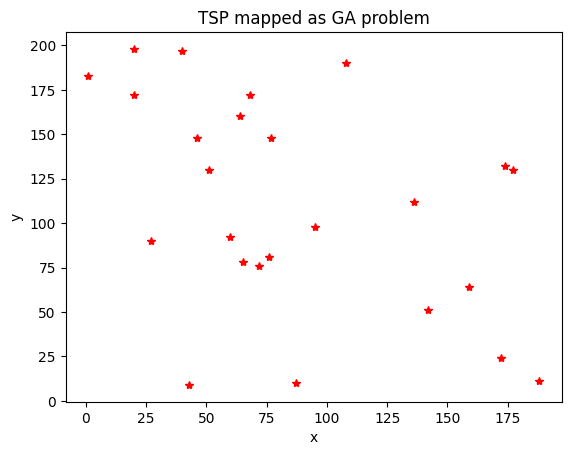

In [30]:
x = [city.x for city in cityList]
y = [city.y for city in cityList]

plt.plot(x,y,'r*')
plt.title('TSP mapped as GA problem')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [31]:
# Testing the previous implementation
popSize = 100
population = cityList
eliteSize = 20
pop = initialPopulation(popSize, population)
print(pop)
popRanked = rankRoutes(pop)
print(popRanked)
selectionResults = selection(popRanked, eliteSize)
print(selectionResults)
matingpool = matingPool(pop, selectionResults)
print(len(matingpool))
print(matingpool)
children = breedPopulation(matingpool, eliteSize)
print(len(children))
nextGeneration = mutatePopulation(children, 0.01)
print(len(nextGeneration))

[[(76,81), (159,64), (65,78), (46,148), (72,76), (1,183), (51,130), (43,9), (188,11), (136,112), (95,98), (108,190), (174,132), (60,92), (172,24), (20,198), (20,172), (40,197), (177,130), (142,51), (87,10), (64,160), (27,90), (77,148), (68,172)], [(174,132), (20,172), (142,51), (65,78), (77,148), (188,11), (172,24), (95,98), (136,112), (64,160), (72,76), (46,148), (1,183), (76,81), (87,10), (108,190), (43,9), (27,90), (40,197), (20,198), (177,130), (60,92), (159,64), (51,130), (68,172)], [(72,76), (43,9), (1,183), (188,11), (65,78), (76,81), (68,172), (77,148), (20,198), (142,51), (46,148), (95,98), (51,130), (64,160), (27,90), (60,92), (174,132), (172,24), (136,112), (40,197), (87,10), (159,64), (108,190), (177,130), (20,172)], [(27,90), (40,197), (76,81), (43,9), (77,148), (72,76), (68,172), (108,190), (46,148), (87,10), (20,172), (51,130), (95,98), (20,198), (172,24), (65,78), (64,160), (142,51), (177,130), (188,11), (174,132), (60,92), (1,183), (136,112), (159,64)], [(87,10), (108,

In [32]:
print(len(popRanked))
print(len(selectionResults))

100
100


In [33]:
popRanked[0]

(13, 0.00047748591904495574)

In [34]:
N = 10
population_CA_name = []
for i in range(0,100,10):
  arr = []
  for x in range(0,N):
    arr.append(x+i)
  population_CA_name.append(arr)

population_CA_name = np.array(population_CA_name)
print(population_CA_name)

[[ 0  1  2  3  4  5  6  7  8  9]
 [10 11 12 13 14 15 16 17 18 19]
 [20 21 22 23 24 25 26 27 28 29]
 [30 31 32 33 34 35 36 37 38 39]
 [40 41 42 43 44 45 46 47 48 49]
 [50 51 52 53 54 55 56 57 58 59]
 [60 61 62 63 64 65 66 67 68 69]
 [70 71 72 73 74 75 76 77 78 79]
 [80 81 82 83 84 85 86 87 88 89]
 [90 91 92 93 94 95 96 97 98 99]]


In [35]:
population_CA_cells = np.random.choice([0, 1], size=(N,N))
population_CA_cells_null_padded =  np.pad(population_CA_cells, [(1, 1), (1, 1)], mode='constant', constant_values=0)

print(population_CA_cells_null_padded)

[[0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 1 0 0 1 1 0 1 1 0]
 [0 1 0 0 0 0 0 0 1 1 0 0]
 [0 1 0 0 1 1 0 0 0 0 0 0]
 [0 1 0 0 0 1 1 0 1 1 0 0]
 [0 1 0 1 1 1 1 0 0 1 0 0]
 [0 0 1 1 0 0 0 0 1 1 0 0]
 [0 0 1 0 0 1 1 1 0 1 0 0]
 [0 0 0 1 0 1 0 0 1 1 1 0]
 [0 1 1 0 1 1 0 1 0 0 1 0]
 [0 1 0 1 0 1 0 0 1 1 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]]


In [36]:
# send the max distance of 8 or less neighbours
def find_distance(arr,popRanked):
  max_fitness = 0
  cell = -1
  for i in range(len(arr)):
    for x in range(len(popRanked)):
      if(arr[i] == popRanked[x][0]):
        distance = popRanked[x][1]
        if(distance > max_fitness):
          max_fitness = distance
          cell = popRanked[x][0]

  return max_fitness,cell

In [37]:
# popRanked = [(59, 0.0004552725835690138), (30, 0.0004420110405079155), ....]
# Ignoring the elite List
# temp_arr[i,j-1] + temp_arr[i,j+1] + temp_arr[i-1,j-1] + temp_arr[i-1,j] + temp_arr[i-1,j+1] + temp_arr[i+1,j-1] + temp_arr[i+1,j] + temp_arr[i+1,j+1]
def selection_CA(popRanked, eliteSize,population_CA_cells_null_padded):
    selectionResults = []
    for i in range(1,N+1):
      for j in range(1,N+1):
        cell_index_i = i - 1
        cell_index_j = j - 1
        if(population_CA_cells_null_padded[i][j] == 1):
          neighbors = []
          if(cell_index_i > 0 and cell_index_i < N and cell_index_j -1 > 0 and cell_index_j - 1 < N):
            neighbors.append(population_CA_name[cell_index_i][cell_index_j-1])
          if(cell_index_i > 0 and cell_index_i < N and cell_index_j + 1 > 0 and cell_index_j + 1 < N):
            neighbors.append(population_CA_name[cell_index_i][cell_index_j+1])
          if(cell_index_i - 1 > 0 and cell_index_i - 1 < N and cell_index_j - 1 > 0 and cell_index_j - 1 < N):
            neighbors.append(population_CA_name[cell_index_i-1][cell_index_j-1])
          if(cell_index_i - 1 > 0 and cell_index_i - 1 < N and cell_index_j > 0 and cell_index_j< N):
            neighbors.append(population_CA_name[cell_index_i-1][cell_index_j])
          if(cell_index_i - 1 > 0 and cell_index_i - 1 < N and cell_index_j + 1 > 0 and cell_index_j + 1 < N):
            neighbors.append(population_CA_name[cell_index_i-1][cell_index_j+1])
          if(cell_index_i + 1 > 0 and cell_index_i + 1 < N and cell_index_j - 1 > 0 and cell_index_j - 1 < N):
            neighbors.append(population_CA_name[cell_index_i+1][cell_index_j-1])
          if(cell_index_i + 1 > 0 and cell_index_i + 1 < N and cell_index_j > 0 and cell_index_j < N):
            neighbors.append(population_CA_name[cell_index_i+1][cell_index_j])
          if(cell_index_i + 1 > 0 and cell_index_i + 1 < N and cell_index_j + 1 > 0 and cell_index_j + 1 < N):
            neighbors.append(population_CA_name[cell_index_i+1][cell_index_j+1])

          maxdistance,cellname = find_distance(neighbors,popRanked)
          selectionResults.append([population_CA_name[cell_index_i][cell_index_j],cellname])

    return selectionResults

In [38]:
# Testing
newselects = selection_CA(popRanked,20,population_CA_cells_null_padded)
print(len(newselects))
print(newselects)

49
[[0, 11], [2, 13], [5, 16], [6, 17], [8, 17], [9, 19], [10, 11], [17, 28], [18, 28], [20, 11], [23, 13], [24, 13], [30, 41], [34, 33], [35, 36], [37, 28], [38, 28], [40, 51], [42, 32], [43, 32], [44, 33], [45, 36], [48, 59], [51, 41], [52, 63], [57, 67], [58, 67], [61, 72], [64, 75], [65, 75], [66, 67], [68, 67], [72, 82], [74, 75], [77, 67], [78, 67], [79, 68], [80, 71], [81, 72], [83, 94], [84, 94], [86, 75], [89, 79], [90, 91], [92, 93], [94, 95], [97, 98], [98, 87], [99, 98]]


In [39]:
def matingPool_CA(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index_0 = selectionResults[i][0]
        index_1 = selectionResults[i][1]
        # print(index_0)
        # print(index_1)
        matingpool.append([population[index_0],population[index_1]])
    return matingpool

In [40]:
# Testing
matingpool = matingPool_CA(pop, newselects)
print(len(matingpool))
print(matingpool)

49
[[[(76,81), (159,64), (65,78), (46,148), (72,76), (1,183), (51,130), (43,9), (188,11), (136,112), (95,98), (108,190), (174,132), (60,92), (172,24), (20,198), (20,172), (40,197), (177,130), (142,51), (87,10), (64,160), (27,90), (77,148), (68,172)], [(159,64), (43,9), (40,197), (46,148), (87,10), (20,198), (95,98), (77,148), (27,90), (172,24), (76,81), (188,11), (142,51), (20,172), (177,130), (65,78), (136,112), (72,76), (64,160), (108,190), (174,132), (51,130), (1,183), (68,172), (60,92)]], [[(72,76), (43,9), (1,183), (188,11), (65,78), (76,81), (68,172), (77,148), (20,198), (142,51), (46,148), (95,98), (51,130), (64,160), (27,90), (60,92), (174,132), (172,24), (136,112), (40,197), (87,10), (159,64), (108,190), (177,130), (20,172)], [(174,132), (43,9), (65,78), (1,183), (20,198), (95,98), (142,51), (172,24), (87,10), (72,76), (177,130), (77,148), (46,148), (188,11), (27,90), (60,92), (64,160), (20,172), (40,197), (68,172), (136,112), (108,190), (51,130), (76,81), (159,64)]], [[(65,78

In [41]:
def breedPopulation_CA(matingpool, eliteSize):
    children = []
    length = len(matingpool)

    for i in range(0,length):
      child = breed(matingpool[i][0],matingpool[i][1])
      children.append(child)
    return children

In [42]:
breeding = breedPopulation_CA(matingpool,20)
print(len(breeding))
print(breeding)

49
[[(177,130), (142,51), (87,10), (64,160), (27,90), (77,148), (159,64), (43,9), (40,197), (46,148), (20,198), (95,98), (172,24), (76,81), (188,11), (20,172), (65,78), (136,112), (72,76), (108,190), (174,132), (51,130), (1,183), (68,172), (60,92)], [(188,11), (65,78), (76,81), (68,172), (77,148), (20,198), (142,51), (46,148), (95,98), (51,130), (64,160), (27,90), (60,92), (174,132), (172,24), (136,112), (43,9), (1,183), (87,10), (72,76), (177,130), (20,172), (40,197), (108,190), (159,64)], [(51,130), (108,190), (177,130), (60,92), (172,24), (136,112), (188,11), (76,81), (64,160), (87,10), (77,148), (46,148), (174,132), (43,9), (65,78), (27,90), (72,76), (20,172), (68,172), (159,64), (142,51), (20,198), (40,197), (95,98), (1,183)], [(95,98), (43,9), (72,76), (142,51), (60,92), (64,160), (51,130), (20,198), (65,78), (172,24), (177,130), (27,90), (76,81), (40,197), (188,11), (68,172), (77,148), (159,64), (46,148), (174,132), (136,112), (108,190), (20,172), (1,183), (87,10)], [(72,76), (1

In [43]:
mutation = mutatePopulation(breeding,0.01)
print(len(mutation))
print(mutation)

49
[[(177,130), (142,51), (87,10), (64,160), (27,90), (77,148), (159,64), (43,9), (40,197), (46,148), (20,198), (95,98), (172,24), (76,81), (188,11), (20,172), (65,78), (136,112), (72,76), (108,190), (174,132), (51,130), (1,183), (68,172), (60,92)], [(188,11), (65,78), (76,81), (68,172), (77,148), (20,198), (142,51), (46,148), (95,98), (51,130), (64,160), (27,90), (60,92), (174,132), (172,24), (136,112), (43,9), (1,183), (87,10), (72,76), (177,130), (20,172), (40,197), (108,190), (159,64)], [(51,130), (108,190), (177,130), (60,92), (172,24), (136,112), (188,11), (76,81), (64,160), (87,10), (77,148), (46,148), (174,132), (43,9), (65,78), (27,90), (72,76), (20,172), (68,172), (159,64), (142,51), (20,198), (40,197), (95,98), (1,183)], [(95,98), (43,9), (72,76), (142,51), (60,92), (64,160), (51,130), (20,198), (65,78), (172,24), (177,130), (27,90), (76,81), (40,197), (188,11), (68,172), (77,148), (159,64), (46,148), (174,132), (136,112), (108,190), (20,172), (1,183), (87,10)], [(72,76), (1

In [44]:
#Evolve CA

def evolve_CA_rule2(population_CA_cells_null_padded,N,iterations):
  # Rule 2
  temp_arr = population_CA_cells_null_padded
  out_arr = np.zeros((N+2,N+2))
  living_cells_rule2 = []
  for itr in range(iterations):
    for i in range(1,N+1):
      for j in range(1,N+1):
        sum = temp_arr[i,j-1] + temp_arr[i,j+1] + temp_arr[i-1,j-1] + temp_arr[i-1,j] + temp_arr[i-1,j+1] + temp_arr[i+1,j-1] + temp_arr[i+1,j] + temp_arr[i+1,j+1]
        if(temp_arr[i][j] == 1):
          if(sum == 1 or sum == 2 or sum == 3 or sum == 4):
            out_arr[i,j] = 1
          else:
            out_arr[i,j] = 0
        else:
          if(sum == 4 or sum == 5 or sum == 6 or sum == 7):
            out_arr[i,j] = 1
          else:
            out_arr[i,j] = 0

    temp_arr = out_arr
    living_cells_rule2.append(np.sum(out_arr))
    out_arr = np.zeros((N+2,N+2))
  return temp_arr

In [45]:
evlove_temp_rule2 = evolve_CA_rule2(population_CA_cells_null_padded,N,1)
print(evlove_temp_rule2)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0.]
 [0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0.]
 [0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0.]
 [0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
 [0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0.]
 [0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [46]:
def place_new_children(population,mutated_result,newselects):
  for i in range(len(newselects)):
    index = newselects[i][0]
    population[index] = mutated_result[i]
  return population


In [47]:
newpop = place_new_children(pop,mutation,newselects)
print(len(newpop))
print(newpop)

100
[[(177,130), (142,51), (87,10), (64,160), (27,90), (77,148), (159,64), (43,9), (40,197), (46,148), (20,198), (95,98), (172,24), (76,81), (188,11), (20,172), (65,78), (136,112), (72,76), (108,190), (174,132), (51,130), (1,183), (68,172), (60,92)], [(174,132), (20,172), (142,51), (65,78), (77,148), (188,11), (172,24), (95,98), (136,112), (64,160), (72,76), (46,148), (1,183), (76,81), (87,10), (108,190), (43,9), (27,90), (40,197), (20,198), (177,130), (60,92), (159,64), (51,130), (68,172)], [(188,11), (65,78), (76,81), (68,172), (77,148), (20,198), (142,51), (46,148), (95,98), (51,130), (64,160), (27,90), (60,92), (174,132), (172,24), (136,112), (43,9), (1,183), (87,10), (72,76), (177,130), (20,172), (40,197), (108,190), (159,64)], [(27,90), (40,197), (76,81), (43,9), (77,148), (72,76), (68,172), (108,190), (46,148), (87,10), (20,172), (51,130), (95,98), (20,198), (172,24), (65,78), (64,160), (142,51), (177,130), (188,11), (174,132), (60,92), (1,183), (136,112), (159,64)], [(87,10), (

**Running the Hybrid Genetic Algorithm for 500 generations**

In [48]:
def nextGeneration_hybridCA(currentGen, eliteSize, mutationRate,population_CA_cells_null_padded,N):
  popRanked = rankRoutes(currentGen)
  selectionResults = selection_CA(popRanked, eliteSize, population_CA_cells_null_padded)
  matingpool = matingPool_CA(currentGen, selectionResults)
  children = breedPopulation_CA(matingpool, eliteSize)
  nextGeneration = mutatePopulation(children, mutationRate)
  evolve_temp_rule2 = evolve_CA_rule2(population_CA_cells_null_padded,N,1)
  return nextGeneration,selectionResults,evolve_temp_rule2

In [49]:
def geneticAlgorithmPlot_HybridGA(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    progress = []

    N = 10
    population_CA_name = []
    for i in range(0,100,10):
      arr = []
      for x in range(0,N):
        arr.append(x+i)
        population_CA_name.append(arr)

    population_CA_name = np.array(population_CA_name)
    population_CA_cells = np.random.choice([0, 1], size=(N,N))
    population_CA_cells_null_padded =  np.pad(population_CA_cells, [(1, 1), (1, 1)], mode='constant', constant_values=0)

    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1])) # Inverse to get the distane from fitness score
    progress.append(1 / rankRoutes(pop)[0][1])

    for i in range(0, generations):
      nextGeneration,selectionResults,evolve_temp_rule2 = nextGeneration_hybridCA(pop, eliteSize, mutationRate, population_CA_cells_null_padded, N)
      pop = place_new_children(pop,nextGeneration,selectionResults)
      progress.append(1 / rankRoutes(pop)[0][1])

    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.show()

    return bestRoute

Initial distance: 1831.5694587936034
Final distance: 1760.9294505614332


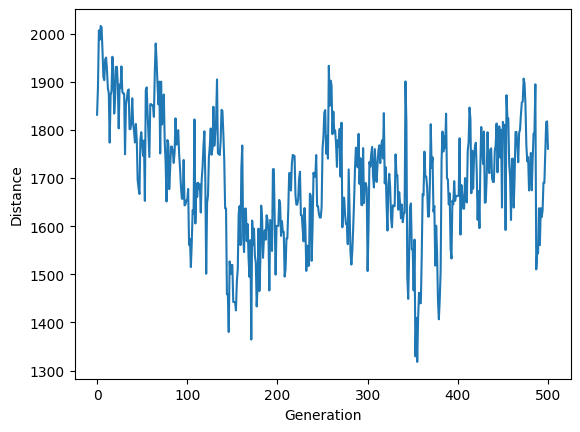

[(76,81), (159,64), (172,24), (142,51), (177,130), (174,132), (72,76), (43,9), (87,10), (188,11), (68,172), (20,198), (136,112), (40,197), (108,190), (95,98), (77,148), (51,130), (46,148), (65,78), (60,92), (64,160), (1,183), (20,172), (27,90)]


In [50]:
bestroute = geneticAlgorithmPlot_HybridGA(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=500)
print(bestroute)

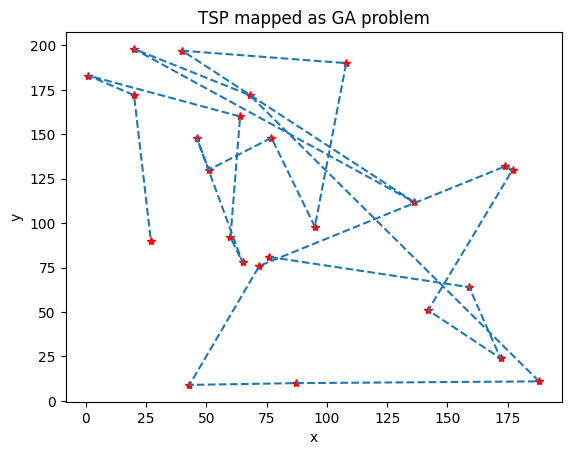

[(76,81), (159,64), (172,24), (142,51), (177,130), (174,132), (72,76), (43,9), (87,10), (188,11), (68,172), (20,198), (136,112), (40,197), (108,190), (95,98), (77,148), (51,130), (46,148), (65,78), (60,92), (64,160), (1,183), (20,172), (27,90)]


In [51]:
x = [city.x for city in cityList]
y = [city.y for city in cityList]

route_point_x = [bestroute[i].x for i in range(len(bestroute))]
route_point_y = [bestroute[i].y for i in range(len(bestroute))]

plt.plot(x,y,'r*')
plt.plot(route_point_x,route_point_y,'--')
plt.title('TSP mapped as GA problem')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

print(bestroute)

**Evolving Hybrid GA using Rule 3 with NULL boundary conditions**

In [52]:
#Evolve CA
def evolve_CA_rule3(population_CA_cells_null_padded,N,iterations):
  # Rule 2
  temp_arr = population_CA_cells_null_padded
  out_arr = np.zeros((N+2,N+2))
  living_cells_rule3 = []
  for itr in range(iterations):
    for i in range(1,N+1):
      for j in range(1,N+1):
        sum = temp_arr[i,j-1] + temp_arr[i,j+1] + temp_arr[i-1,j-1] + temp_arr[i-1,j] + temp_arr[i-1,j+1] + temp_arr[i+1,j-1] + temp_arr[i+1,j] + temp_arr[i+1,j+1]
        if(temp_arr[i][j] == 1):
          if(sum == 2 or sum == 4 or sum == 6 or sum == 8):
            out_arr[i,j] = 1
          else:
            out_arr[i,j] = 0
        else:
          if(sum == 1 or sum == 3 or sum == 7 or sum == 7):
            out_arr[i,j] = 1
          else:
            out_arr[i,j] = 0

    temp_arr = out_arr
    living_cells_rule3.append(np.sum(out_arr))
    out_arr = np.zeros((N+2,N+2))
  return temp_arr

In [53]:
def nextGeneration_hybridCA_rule3(currentGen, eliteSize, mutationRate,population_CA_cells_null_padded,N):
  popRanked = rankRoutes(currentGen)
  selectionResults = selection_CA(popRanked, eliteSize, population_CA_cells_null_padded)
  matingpool = matingPool_CA(currentGen, selectionResults)
  children = breedPopulation_CA(matingpool, eliteSize)
  nextGeneration = mutatePopulation(children, mutationRate)
  evolve_temp_rule3 = evolve_CA_rule3(population_CA_cells_null_padded,N,1)
  return nextGeneration,selectionResults,evolve_temp_rule3

In [54]:
def geneticAlgorithmPlot_HybridGA_rule3(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    progress = []

    N = 10
    population_CA_name = []
    for i in range(0,100,10):
      arr = []
      for x in range(0,N):
        arr.append(x+i)
        population_CA_name.append(arr)

    population_CA_name = np.array(population_CA_name)
    population_CA_cells = np.random.choice([0, 1], size=(N,N))
    population_CA_cells_null_padded =  np.pad(population_CA_cells, [(1, 1), (1, 1)], mode='constant', constant_values=0)

    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1])) # Inverse to get the distane from fitness score
    progress.append(1 / rankRoutes(pop)[0][1])

    for i in range(0, generations):
      nextGeneration,selectionResults,evolve_temp_rule2 = nextGeneration_hybridCA_rule3(pop, eliteSize, mutationRate, population_CA_cells_null_padded, N)
      pop = place_new_children(pop,nextGeneration,selectionResults)
      progress.append(1 / rankRoutes(pop)[0][1])

    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.show()

    return bestRoute

Initial distance: 2083.8242433605274
Final distance: 1592.1763729253673


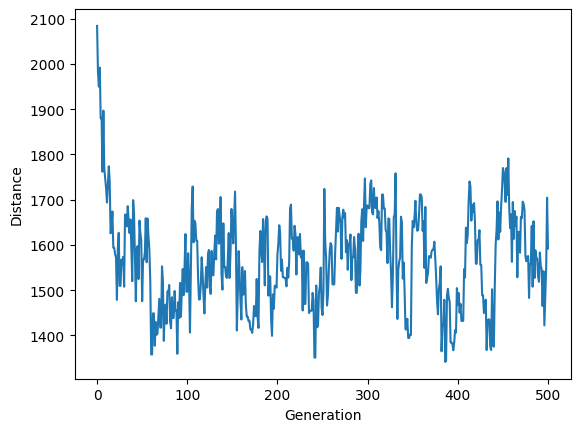

[(87,10), (43,9), (159,64), (188,11), (172,24), (174,132), (51,130), (95,98), (1,183), (20,172), (40,197), (20,198), (108,190), (68,172), (64,160), (46,148), (136,112), (142,51), (60,92), (177,130), (77,148), (27,90), (76,81), (72,76), (65,78)]


In [55]:
bestroute = geneticAlgorithmPlot_HybridGA_rule3(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=500)
print(bestroute)

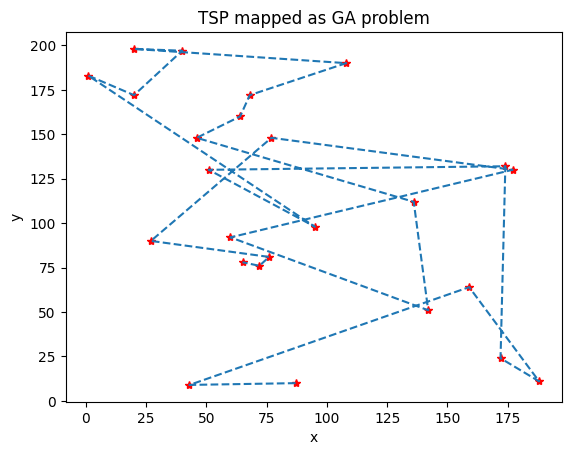

[(87,10), (43,9), (159,64), (188,11), (172,24), (174,132), (51,130), (95,98), (1,183), (20,172), (40,197), (20,198), (108,190), (68,172), (64,160), (46,148), (136,112), (142,51), (60,92), (177,130), (77,148), (27,90), (76,81), (72,76), (65,78)]


In [56]:
x = [city.x for city in cityList]
y = [city.y for city in cityList]

route_point_x = [bestroute[i].x for i in range(len(bestroute))]
route_point_y = [bestroute[i].y for i in range(len(bestroute))]

plt.plot(x,y,'r*')
plt.plot(route_point_x,route_point_y,'--')
plt.title('TSP mapped as GA problem')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

print(bestroute)